# 30254 - ML for Public Policy HW4 - Nora Hajjar

## HW Assignment 4 - Clustering: 

The goal of this homework assignment is to build an interactive clustering tool. 

Coding Assignment:
Develop a data exploration notebook that is interactive and uses clustering methods. Feel free
to just use k-means for this homework.
The functionality should include:
1. load data from a csv
2. process the data so it’s ready for clustering
3. Given a k, generate k clusters using one of the clustering methods (k-means is fine for this)
4. For each cluster:
A. Provide summary stats for the cluster
B. Describe (using statistics, graphs, or any other visualizations) what types of data
points are in this cluster
C. what are the distinctive features of data points in this cluster (you might want to use
decision trees here)
5. Allow the user to
A. merge several clusters into one
B. recluster with a new k
C. Split a specific cluster into many (with a specific number of new clustering)
Analysis:
Data: projects_2012_2013.csv
6. Once you've set up clustering code, you should apply it to the data from the previous
homework to understand what types of projects are submitted added and also what type of
projects are predicted as high risk of not getting fully funded (output of your last homework).
Report:
You should also write a short report (1-2 pages) that describes what types of clusters you found
and what were the characteristics of projects in those clusters for:
A. the overall submitted projects
B. the top 5% of predicted projects from your test set that were not likely to be fully funded by
your model.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import final_pipeline as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 1) load data from a csv

In [3]:
df = p.load_data('projects_2012_2013.csv')

### 2) process the data so it’s ready for clustering

In [4]:
#show null counts
null_counts = p.check_null_counts(df)
null_counts

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

In [5]:
#drop columns that are irrelevant/too many nulls
df.drop(['school_ncesid', 'school_metro', 'secondary_focus_subject', 'secondary_focus_area'], axis=1, inplace=True)

In [6]:
#drop NA values for columns we can't fill in with avg
df.dropna(subset=['primary_focus_subject', 'primary_focus_area','resource_type', 'grade_level', 'school_district'], inplace=True)

In [7]:
#rest of nulls we will fill in after train/test splits 
#b/c numeric so we can fill in with avg
null_counts = p.check_null_counts(df)
null_counts

projectid                                  0
teacher_acctid                             0
schoolid                                   0
school_latitude                            0
school_longitude                           0
school_city                                0
school_state                               0
school_district                            0
school_county                              0
school_charter                             0
school_magnet                              0
teacher_prefix                             0
primary_focus_subject                      0
primary_focus_area                         0
resource_type                              0
poverty_level                              0
grade_level                                0
total_price_including_optional_support     0
students_reached                          53
eligible_double_your_impact_match          0
date_posted                                0
datefullyfunded                            0
dtype: int

In [8]:
#convert the dates to the appropriate type
p.convert_to_datetime(df, ['date_posted', 'datefullyfunded'])
df.dtypes

projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_district                                   object
school_county                                     object
school_charter                                    object
school_magnet                                     object
teacher_prefix                                    object
primary_focus_subject                             object
primary_focus_area                                object
resource_type                                     object
poverty_level                                     object
grade_level                                       object
total_price_including_optional_

In [9]:
#create our date_diff column
df['days_to_funded'] = df.datefullyfunded - df.date_posted

In [10]:
p.convert_column_type(df, 'days_to_funded', 'timedelta64[D]')

In [11]:
df['not_fully_funded_60'] = df['days_to_funded'] > 60.0

In [12]:
df['not_fully_funded_60'] = df['not_fully_funded_60'] * 1

In [13]:
#clean train/test data
cat_cols = ['school_state', 'school_city', 'school_district', 'school_county', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level']
disc_cols = ['total_price_including_optional_support', 'students_reached']
p.clean_data([df], cat_cols, disc_cols)

In [14]:
df

,projectid,teacher_acctid,schoolid,school_latitude,school_longitude,school_city,school_state,school_district,school_county,school_charter,...,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded,days_to_funded,not_fully_funded_60
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,41.807654,-87.673257,921,14,4089,309,0,...,2,1,3,0,0,0,2013-04-14,2013-05-02,18.0,0
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,34.296596,-119.296596,5460,4,5484,1356,0,...,0,1,0,0,0,1,2012-04-07,2012-04-18,11.0,0
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,34.078625,-118.257834,3025,4,2986,774,0,...,3,0,0,0,0,0,2012-01-30,2012-04-15,76.0,1
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,40.687286,-73.988217,612,34,3633,697,0,...,0,0,3,0,0,0,2012-10-11,2012-12-05,55.0,0
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,40.793018,-73.205635,855,34,873,1264,0,...,3,0,3,0,0,0,2013-01-08,2013-03-25,76.0,1
5,00049ec8ca1f2d08cb13cab31b0b85ec,7149611553c700de9a6099f8a9ce598b,462a5fd93cf9fb5d41eecfd2ea860b19,42.740157,-84.525821,2839,22,2780,639,0,...,1,1,0,0,0,0,2012-11-30,2013-02-26,88.0,1
6,0004d2fdbb571237fa53a97e7691440b,926671e209fb977bd5123145c1848ad1,1a994778027ab086dc58ec3b47f74ff0,33.059361,-112.037727,3173,3,3130,1033,0,...,2,0,0,0,0,0,2013-03-26,2013-04-17,22.0,0
7,0004ee26667e751dd51384eb9f30c72e,abe4dabb7864f4c548d230cf9070e03f,8409f70bcd81bc06e4b9efca68eed8f6,37.761958,-122.193209,3862,4,3851,11,0,...,0,1,2,0,0,0,2013-02-28,2013-03-10,10.0,0
8,0006a31d45f8d52d217e7c5b55c11f37,3b5fada1ad0e339acc669829071320c4,c6a033f9349ea70659c1891b119680ed,44.096641,-70.191734,2924,21,2866,34,0,...,3,0,0,0,0,0,2013-08-21,2013-09-13,23.0,0
9,0008ac907bf237a15a959244205d3ee5,92527a5ac5fe946ed1961fb2e1de8cc5,23e34f5d2e2940684269cffe35741598,34.381832,-118.531837,3747,4,3648,774,0,...,3,1,3,0,0,0,2012-10-03,2012-11-03,31.0,0


### 3) Given a k, generate k clusters using one of the clustering methods (k-means is fine for this)

In [15]:
dep_var = 'not_fully_funded_60'
pred_vars = ['total_price_including_optional_support',
        'students_reached',
       'eligible_double_your_impact_match', 
       'school_state',
       'school_city', 
       'school_district', 
       'school_county',
       'school_charter', 
       'school_magnet', 
       'teacher_prefix',
       'primary_focus_subject', 
       'primary_focus_area',
       'resource_type', 
       'poverty_level', 
       'grade_level']

In [84]:
X = df[['total_price_including_optional_support',
        'students_reached',
       'eligible_double_your_impact_match', 
       'school_state',
       'school_city', 
       'school_district', 
       'school_county',
       'school_charter', 
       'school_magnet', 
       'teacher_prefix',
       'primary_focus_subject', 
       'primary_focus_area',
       'resource_type', 
       'poverty_level', 
       'grade_level', 'not_fully_funded_60']]
km = KMeans(n_clusters=4,  init='random', n_init=1 , max_iter = 1, random_state=1)
km_fit = km.fit(X)
preds = km.predict(X)
preds

array([1, 2, 0, ..., 2, 0, 0], dtype=int32)

In [78]:
centroids = km.cluster_centers_.tolist()
centroids

[[0.0001898408049251112,
  8.136034496790371e-05,
  0.32766522930054864,
  18.650231876983543,
  3472.119464106875,
  3311.0010305646697,
  736.0352290293737,
  0.11216879559568589,
  0.08247226968242269,
  2.2657500067800362,
  14.91229354812465,
  3.309955794212562,
  1.9197786998616646,
  1.0268217937244075,
  1.5954763648197885,
  0.295880454533121],
 [0.00010011847352698903,
  8.343206127251515e-05,
  0.28720652772447663,
  22.319961954980656,
  1527.7921540494942,
  1861.0750387969822,
  621.1379799429944,
  0.07393749269968244,
  0.09417811076440065,
  2.259573829031023,
  14.980410152013146,
  3.356104723923301,
  1.8760533297735702,
  1.073620450866868,
  1.5688564801682006,
  0.29082747918369933],
 [-1.1695830935687379e-17,
  -2.9680034471790684e-18,
  0.23525498891353078,
  21.696563192904545,
  5090.124057649977,
  5211.520953436895,
  646.3595343680668,
  0.08425720620842722,
  0.05931263858093751,
  2.2260532150776084,
  14.885033259423512,
  3.318514412416851,
  1.849556

In [82]:
y = km.predict(X).tolist()
y

[1,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 3,
 1,
 0,
 3,
 3,
 1,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 2,
 3,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 3,
 0,
 0,
 1,
 3,
 1,
 0,
 3,
 0,
 3,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 3,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 3,
 3,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 3,
 0,
 3,
 1,
 0,
 1,
 1,
 1,
 3,
 1,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 0,
 3,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 3,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 3,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 3,
 2,
 1,
 0,
 3,
 0,
 1,
 1,
 1,
 3,
 3,
 0,
 3,
 0,
 1,
 3,
 1,
 0,
 1,
 0,
 0,
 0,
 3,
 1,
 1,
 3,
 1,
 0,
 0,
 0,
 3,
 3,
 1,
 2,
 0,
 1,
 3,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 0,
 3,
 3,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 0,
 1,
 3,
 1,
 1,
 2,
 1,
 1,
 0,
 3,
 1,
 1,
 1,
 1,
 2,
 3,


In [83]:
#create cluster dataframe 
cluster_df = pd.DataFrame()
for index, colname in enumerate(list(X)):
    cluster_df[colname] = X[colname]
cluster_df['n_cluster_group'] = km_fit.labels_


,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_state,school_city,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,resource_type,poverty_level,grade_level,not_fully_funded_60,n_cluster_group
0,0,0,0,14,921,4089,309,0,0,2,17,4,2,1,3,0,1
1,0,0,1,4,5460,5484,1356,0,0,2,2,2,0,1,0,0,2
2,0,0,0,4,3025,2986,774,0,0,3,15,3,3,0,0,1,0
3,0,0,0,34,612,3633,697,0,1,3,15,3,0,0,3,0,1
4,0,0,0,34,855,873,1264,0,0,2,15,3,3,0,3,1,1
5,0,0,0,22,2839,2780,639,0,0,2,15,3,1,1,0,1,0
6,0,0,0,3,3173,3130,1033,0,0,3,15,3,2,0,0,0,0
7,0,0,0,4,3862,3851,11,0,0,1,17,4,0,1,2,0,0
8,0,0,0,21,2924,2866,34,0,0,2,20,0,3,0,0,0,0
9,0,0,0,4,3747,3648,774,0,0,3,17,4,3,1,3,0,0


In [114]:
test = cluster_df.groupby(by='n_cluster_group')

In [115]:
print(test)

In [20]:
n_clusters = cluster_df.n_cluster_group.unique().tolist()
n_clusters

[1, 2, 0, 3]

### 4) For each cluster:

### A. Provide summary stats for each cluster
### B. Use graphs to describe what types of data points are in this cluster

cluster_group: 1
       eligible_double_your_impact_match  school_state   school_city  \
count                       52271.000000  52271.000000  52271.000000   
mean                            0.285225     22.424499   1306.305619   
std                             0.451526     14.638996    895.082461   
min                             0.000000      0.000000      0.000000   
25%                             0.000000      9.000000    604.000000   
50%                             0.000000     22.000000   1064.000000   
75%                             1.000000     34.000000   1986.000000   
max                             1.000000     50.000000   4377.000000   

       school_district  school_county  school_charter  school_magnet  \
count     52271.000000   52271.000000    52271.000000   52271.000000   
mean       1800.897171     596.943085        0.073922       0.096727   
std        1246.509120     370.579178        0.261647       0.295588   
min           0.000000       0.000000        0

cluster_group: 3
       eligible_double_your_impact_match  school_state   school_city  \
count                       18390.000000  18390.000000  18390.000000   
mean                            0.283796     19.623545   4600.116476   
std                             0.450851     15.682700    649.453821   
min                             0.000000      0.000000   2055.000000   
25%                             0.000000      4.000000   4154.000000   
50%                             0.000000     17.000000   4636.000000   
75%                             1.000000     36.000000   4969.000000   
max                             1.000000     50.000000   5950.000000   

       school_district  school_county  school_charter  school_magnet  \
count      18390.00000   18390.000000    18390.000000   18390.000000   
mean        4117.99391     960.306199        0.107613       0.079554   
std          692.92003     290.963160        0.309899       0.270609   
min         1872.00000       3.000000        0

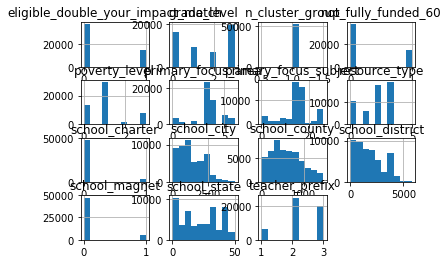

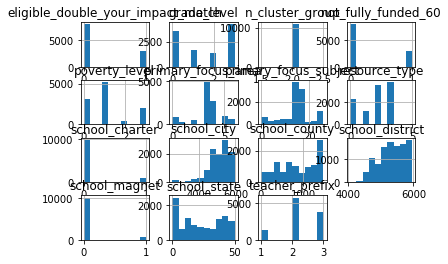

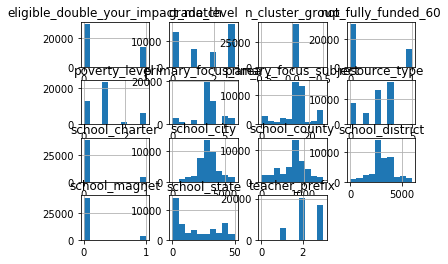

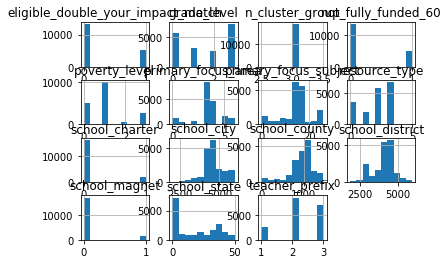

In [21]:
#see summary stats and histograms for part A and B below
for n in n_clusters:
    cluster = cluster_df[cluster_df['n_cluster_group'] == n]
    print('cluster_group:', n)
    print(cluster[cluster.columns].describe())
    cluster.hist()

### C. What are the distinctive features of data points in this cluster? (Use decision trees)

In [22]:
tree = tree.DecisionTreeClassifier(max_depth=4)

In [23]:
decision_tree = tree.fit(X[pred_vars], X[dep_var])

In [24]:
print(decision_tree)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


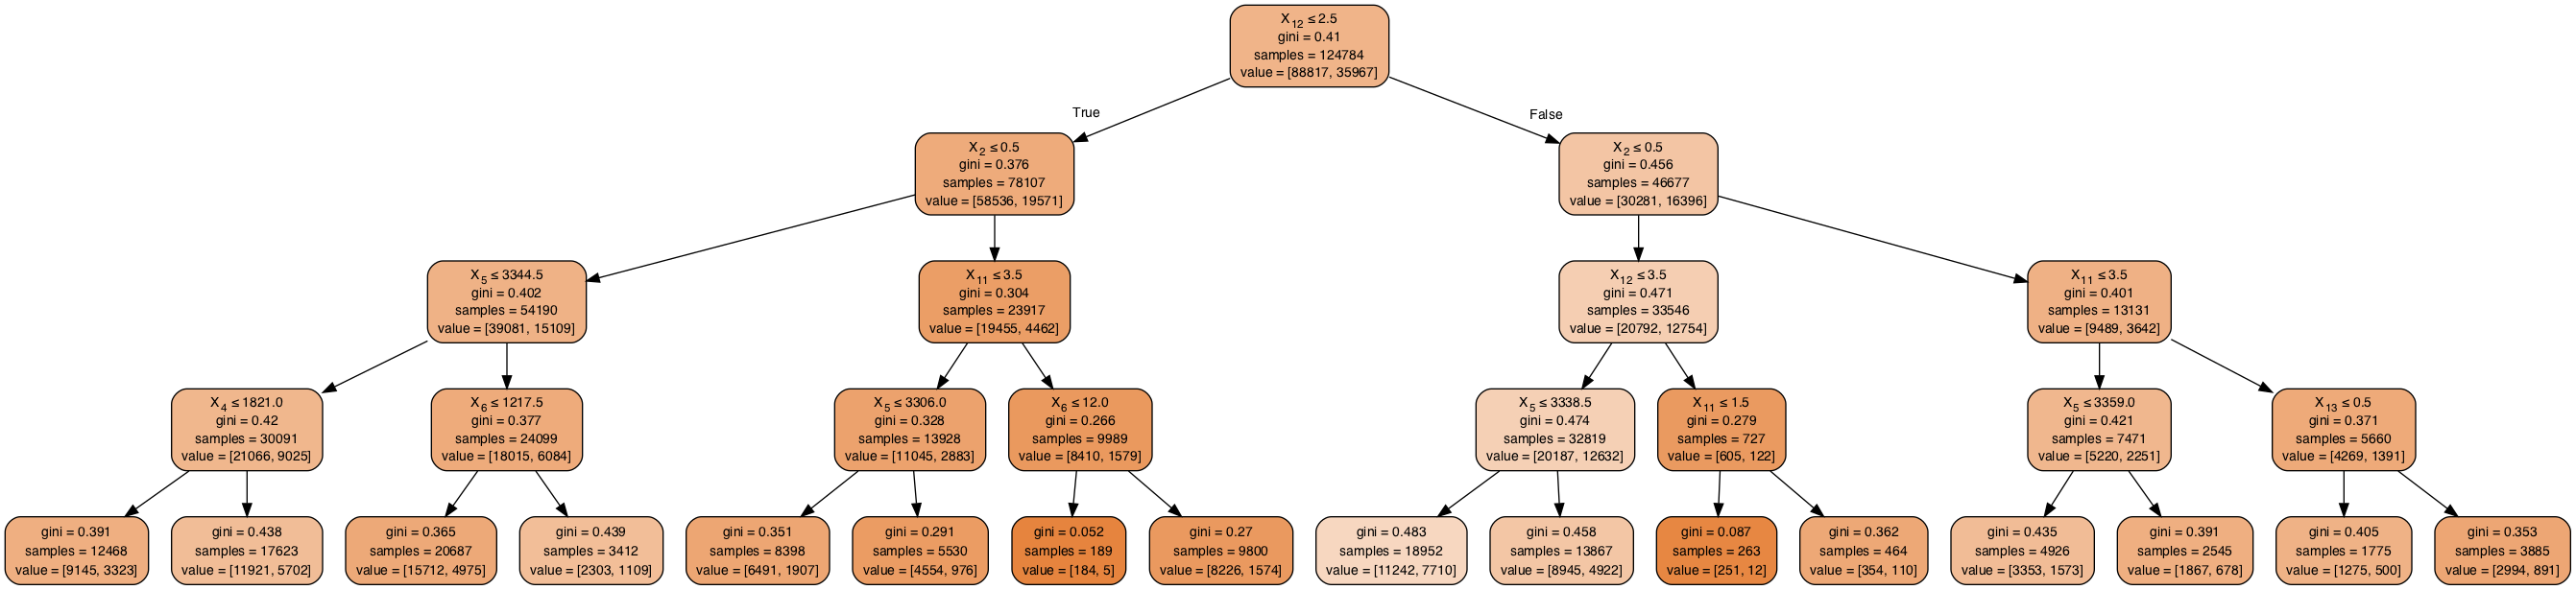

In [25]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [61]:
n_clusters

[1, 2, 0, 3]

In [62]:
cluster_df

,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,school_state,school_city,school_district,school_county,school_charter,school_magnet,teacher_prefix,primary_focus_subject,primary_focus_area,resource_type,poverty_level,grade_level,not_fully_funded_60,n_cluster_group
0,0,0,0,14,921,4089,309,0,0,2,17,4,2,1,3,0,1
1,0,0,1,4,5460,5484,1356,0,0,2,2,2,0,1,0,0,2
2,0,0,0,4,3025,2986,774,0,0,3,15,3,3,0,0,1,0
3,0,0,0,34,612,3633,697,0,1,3,15,3,0,0,3,0,1
4,0,0,0,34,855,873,1264,0,0,2,15,3,3,0,3,1,1
5,0,0,0,22,2839,2780,639,0,0,2,15,3,1,1,0,1,0
6,0,0,0,3,3173,3130,1033,0,0,3,15,3,2,0,0,0,0
7,0,0,0,4,3862,3851,11,0,0,1,17,4,0,1,2,0,0
8,0,0,0,21,2924,2866,34,0,0,2,20,0,3,0,0,0,0
9,0,0,0,4,3747,3648,774,0,0,3,17,4,3,1,3,0,0


In [92]:
df_2 = p.load_data('projects_2012_2013.csv')
#drop NA values for columns we can't fill in with avg
df_2.dropna(subset=['primary_focus_subject', 'primary_focus_area','resource_type', 'grade_level', 'school_district'], inplace=True)

In [106]:
df_2['primary_focus_area'].unique()

#df[df_2['primary_focus_area']].count().sort_values(ascending=False)


array(['Math & Science', 'History & Civics', 'Literacy & Language',
       'Applied Learning', 'Music & The Arts', 'Health & Sports',
       'Special Needs'], dtype=object)

In [105]:
df.groupby('primary_focus_area').size()

primary_focus_area
0     8706
1     3488
2     5151
3    55964
4    31659
5    11473
6     8343
dtype: int64